In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,4)

In [2]:
def bound(noise_scale):
    return 0.001*(2+8*noise_scale)/2
# bound = 0.001*(2*1 + 8*1**2*1**2)/2

In [3]:
ns = [10.0, 2.0, 1.0, 0.8]
bd = []
for n in ns:
    bd.append(bound(n))

In [4]:
with open('results/dict/adult_proposed_fold_0_9112022_234358.pkl', 'rb') as f:
    run_ns_1 = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_234658.pkl', 'rb') as f:
    run_ns_2 = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_234844.pkl', 'rb') as f:
    run_ns_10 = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_235028.pkl', 'rb') as f:
    run_ns_08 = pickle.load(f)

In [5]:
run_ns_1 = max(max(run_ns_1['male_norm']), max(run_ns_1['female_norm']))
run_ns_2 = max(max(run_ns_2['male_norm']), max(run_ns_2['female_norm']))
run_ns_10 = max(max(run_ns_10['male_norm']), max(run_ns_10['female_norm']))
run_ns_08 = max(max(run_ns_08['male_norm']), max(run_ns_08['female_norm']))

In [10]:
run_ns_08

0.0008712258247646725

In [8]:
run_ns_2 # eps = 1

0.0003175511640660903

In [9]:
run_ns_10 # eps = 0.5

0.0006045411053825828

In [28]:
max_imperical_norm = [run_ns_10, run_ns_2, run_ns_1, run_ns_08]

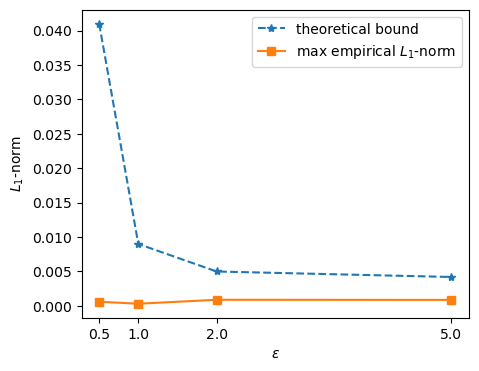

In [42]:
eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(eps, bd, '--*', label='theoretical bound')
plt.plot(eps, max_imperical_norm, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(eps, eps)
plt.legend()

In [3]:
with open('results/dict/adult_fair_fold_0_9112022_194819.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_195457.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/adult_alg1_fold_0_9112022_193928.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

In [4]:
run_fair_dict.keys()

dict_keys(['train_global_history_loss', 'train_male_history_loss', 'train_female_history_loss', 'train_global_history_acc', 'train_male_history_acc', 'train_female_history_acc', 'val_global_history_loss', 'val_male_history_loss', 'val_female_history_loss', 'val_global_history_acc', 'val_male_history_acc', 'val_female_history_acc', 'male_norm', 'female_norm'])

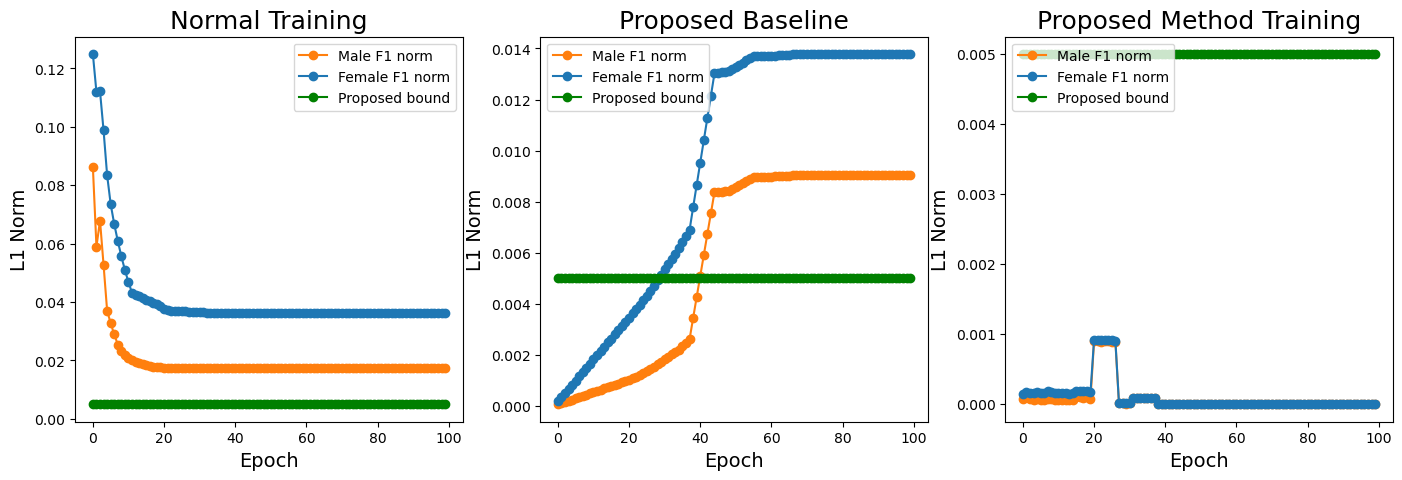

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))

axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

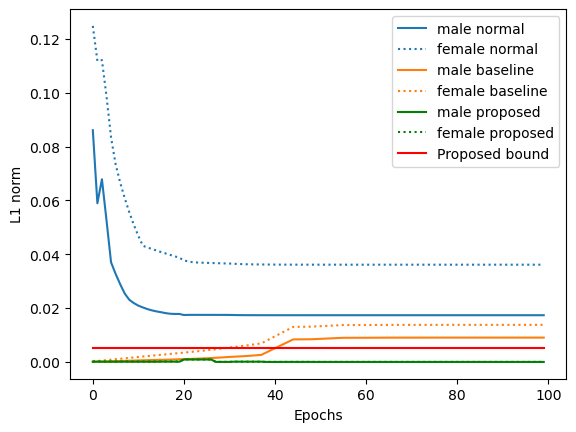

In [17]:
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-',
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':',
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-',
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':',
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-',
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':',
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

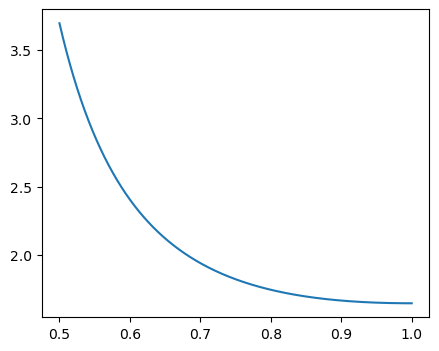

In [38]:
def f(sigma):
    return sigma*np.exp(1/(2*sigma**2))

sig = np.linspace(0.5, 1, 1000)
val = f(sig)
plt.plot(sig, val)